# Introduction to `rasterio` & `atlite`

In this tutorial, we're going to cover two new Python packages:

**Rasterio: access to geospatial raster data**

> Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

:::{note}
Documentation for rasterio is available at https://rasterio.readthedocs.io/en/latest/index.html.
:::

**Atlite: Convert weather data to energy systems data**

> Atlite is a free software, xarray-based Python library for converting weather data (such as wind speeds, solar radiation, temperature and runoff) into power systems data (such as wind power, solar power, hydro power and heating demand time series).

:::{note}
Documentation for atlite is available at https://atlite.readthedocs.io/en/latest/.

This tool is developed here at TU Berlin in the group of Digital Transformation of Energy Systems.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install atlite rasterio geopandas cartopy matplotlib numpy xarray
```
:::



## Download of Required Data

Before we can run this tutorial, we have to download a few input data files to your local filesystem. The cell below uses some Python utility packages to automate the retrieval of the required files.

In [110]:
from urllib.request import urlretrieve
from os.path import basename

url = (
    "https://tubcloud.tu-berlin.de/s/2oogpgBfM5n4ssZ/download/PORTUGAL-2013-01-era5.nc"
)
urlretrieve(url, basename(url));

## Repetition of Vector Data

In the last tutorial, we used `geopandas` to work with **vector data** (e.g. points, lines, polygons):

Importing the package:

In [111]:
import geopandas as gpd

Reading the file:

In [112]:
url = "https://tubcloud.tu-berlin.de/s/7bpHrAkjMT3ADSr/download/country_shapes.geojson"
countries = gpd.read_file(url).set_index("name")

Inspecting the GeoDataFrame:

In [113]:
countries.tail()

,geometry
name,
VN,"MULTIPOLYGON (((107.49807 14.74595, 107.50928 ..."
YE,"MULTIPOLYGON (((52.09954 18.72304, 52.14233 18..."
ZA,"MULTIPOLYGON (((19.99292 -24.77585, 20.01049 -..."
ZM,"POLYGON ((32.92086 -9.4079, 32.92303 -9.46629,..."
ZW,"POLYGON ((25.25978 -17.79411, 25.26671 -17.800..."


:::{note}
This dataset uses ISO-2 country codes as index: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2.
:::

Plotting the GeoDataFrame:

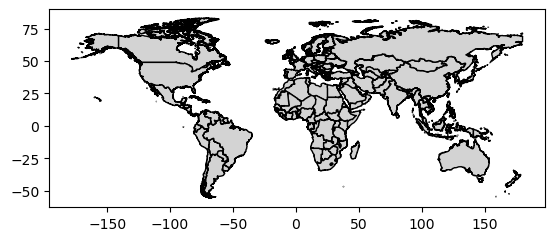

In [114]:
countries.plot(edgecolor="k", facecolor="lightgrey");

Reprojecting geometries in the GeoDataFrame:

In [115]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

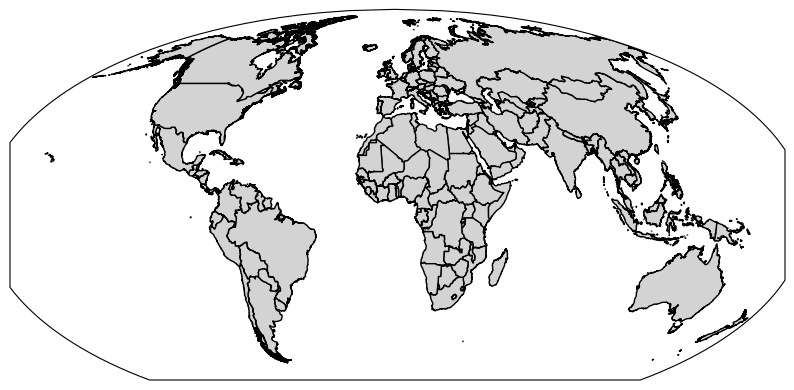

In [116]:
crs = ccrs.Mollweide()

fig = plt.figure(figsize=(10, 5))

ax = plt.axes(projection=crs)

countries.to_crs(crs).plot(ax=ax, edgecolor="k", facecolor="lightgrey");

## Raster Data with `rasterio`

But we haven't worked with **raster data** yet!

One useful package for working with raster data is [`rasterio`](https://rasterio.readthedocs.io/en/latest/):

In [117]:
import rasterio as rio
import numpy as np

With `rasterio`, we can for instance load GeoTIFF files. GeoTIFF is a common format for storing georeferenced raster data such as satellite imagery or land cover classifications. It is like a regular image file (e.g. PNG or JPEG), but it also contains metadata that describes the geographic location and projection of the data.

In the example below, we load the [CORINE land cover classification](https://land.copernicus.eu/pan-european/corine-land-cover) for Portugal:



In [118]:
url = "https://tubcloud.tu-berlin.de/s/Mw5dwbwdsDY8zfH/download/U2018_CLC2018_V2020_20u1-PT.tif"
clc = rio.open(url)

Datasets can have one or more bands (or layers), which can be read with the `.read()` function. A band is similar to a channel in an image (e.g. red, green, blue color). In geospatial raster data, bands can represent different variables, time steps or heights. The counting starts at 1, unlike the rest of Python. Here, we read the first and only band:

In [119]:
band = clc.read(1)

The returned object is a 2-dimensional `numpy.ndarray`. 

In [120]:
type(band)

numpy.ndarray

In [121]:
band.shape

(5662, 3404)

The band values correspond to a land cover and land use classification scheme with class values as listed [here](https://web.archive.org/web/20241104054213/https://collections.sentinel-hub.com/corine-land-cover/readme.html).

> The band values correspond to a land cover and land use classification scheme with class values ranging from 0 to 44. Please see the nomenclature and coloring scheme in the table below. For more details about the classes, please see the official CORINE Land Cover nomenclature guidelines or the illustrated nomenclature guidelines document.A visualisation script can be found in our custom scripts repository.

| Value in Dataset | Identifier / Classification Number | Description |
|--------|-------------|-------------|
| 1 | 111 | Continuous urban fabric |
| 2 | 112 | Discontinuous urban fabric |
| 3 | 121 | Industrial or commercial units |
| 4 | 122 | Road and rail networks and associated land |
| 5 | 123 | Port areas |
| 6 | 124 | Airports |
| 7 | 131 | Mineral extraction sites |
| 8 | 132 | Dump sites |
| 9 | 133 | Construction sites |
| 10 | 141 | Green urban areas |
| 11 | 142 | Sport and leisure facilities |
| 12 | 211 | Non-irrigated arable land |
| 13 | 212 | Permanently irrigated land |
| 14 | 213 | Rice fields |
| 15 | 221 | Vineyards |
| 16 | 222 | Fruit trees and berry plantations |
| 17 | 223 | Olive groves |
| 18 | 231 | Pastures |
| 19 | 241 | Annual crops associated with permanent crops |
| 20 | 242 | Complex cultivation patterns |
| 21 | 243 | Land principally occupied by agriculture with significant areas of natural vegetation |
| 22 | 244 | Agro-forestry areas |
| 23 | 311 | Broad-leaved forest |
| 24 | 312 | Coniferous forest |
| 25 | 313 | Mixed forest |
| 26 | 321 | Natural grasslands |
| 27 | 322 | Moors and heathland |
| 28 | 323 | Sclerophyllous vegetation |
| 29 | 324 | Transitional woodland-shrub |
| 30 | 331 | Beaches - dunes - sands |
| 31 | 332 | Bare rocks |
| 32 | 333 | Sparsely vegetated areas |
| 33 | 334 | Burnt areas |
| 34 | 335 | Glaciers and perpetual snow |
| 35 | 411 | Inland marshes |
| 36 | 412 | Peat bogs |
| 37 | 421 | Salt marshes |
| 38 | 422 | Salines |
| 39 | 423 | Intertidal flats |
| 40 | 511 | Water courses |
| 41 | 512 | Water bodies |
| 42 | 521 | Coastal lagoons |
| 43 | 522 | Estuaries |
| 44 | 523 | Sea and ocean |
| 48 | 999 | NODATA |

This is an example of **categorical values** in raster data.

In [122]:
np.unique(band)

array([-128,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   35,   37,   38,   39,   40,   41,   42,   43,   44],
      dtype=int8)

To plot raster data, the `rasterio.plot.show()` function is commonly used. It automatically labels the axes with geographic coordinates.
The geographic information is stored in the rasters' `.crs`, `.bounds` and `.transform` attributes.

In [123]:
clc.crs

CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]')

In [124]:
clc.bounds

BoundingBox(left=2635400.0, bottom=1732500.0, right=2975800.0, top=2298700.0)

In [125]:
clc.transform

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

This information is then passed to the `rasterio.plot.show()` function:

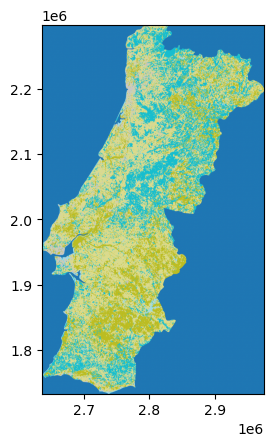

In [126]:
from rasterio.plot import show
show(band, transform=clc.transform, cmap="tab20");

Let's quickly load another dataset with **continuous values**: The elevation and water depth in and around Portugal.

This dataset comes from [GEBCO Gridded Bathymetry Data](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) and has another file format `.nc` (netCDF) which also stores raster data.

It would be useful to exclude very mountainous areas, or identify shallow water at sea for the development of offshore wind turbines.

In [127]:
url = "https://tubcloud.tu-berlin.de/s/XoDpBcweJHmYKgF/download/GEBCO_2014_2D-PT.nc"
gebco = rio.open(url, driver="netcdf")
band = gebco.read(1)

In [128]:
np.unique(band)

array([-2898, -2862, -2856, ...,  1915,  1926,  1959],
      shape=(4184,), dtype=int16)

For plotting, we can also display **vector and raster data together** and add a colorbar:

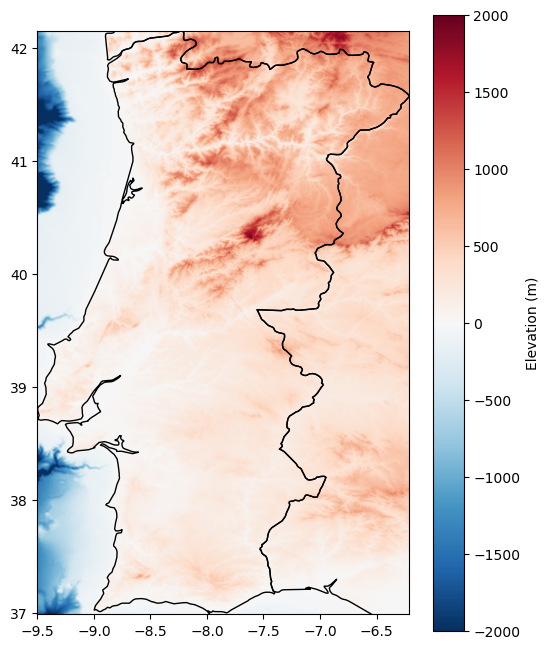

In [129]:
fig, ax = plt.subplots(figsize=(6, 8))

countries.loc[["PT", "ES"]].plot(ax=ax, color="none")

show(band, transform=gebco.transform, cmap="RdBu_r", ax=ax, vmin=-2000, vmax=2000)

plt.colorbar(ax.images[0], ax=ax, label="Elevation (m)");


## Land Eligibility Analysis with `atlite`

To estimate the wind and solar generation potential of a country, land usage constraints need to be taken into account.

The data required to determine the eligible areas is stored in various formats as **raster** and **vector** data.

**Examples:**

- **Vector Data:** natural protection areas, settlements, roads, airports, railways, power lines, water bodies
- **Raster Data:** type of land, elevation, slope, soil type

The [`atlite`](https://atlite.readthedocs.io) library has some useful features to handle exclusion constraints for both datatypes simultaneously.

The core object to do land eligibility analysis in `atlite` is the `ExclusionContainer`, which serves as a container for all rasters and geometries we want to exclude (or include). That means both vector and raster data can be added to this container while specifying what parts of them are exclusion or inclusion criteria.

In [130]:
from atlite.gis import ExclusionContainer

In many cases, rasters and geometries come in different projections and resolutions. Therefore, the `ExclusionContainer` is initialized with a given CRS and a resolution which serves as a basis for all added rasters and geometries. Datasets must be added noting their original CRS. Then, `atlite` takes care of reprojecting and resampling the data to the target resolution. Per default the CRS is [3035](https://epsg.io/3035) with validity within Europe and the resolution 100, which sets a raster of 100 meter resolution. All rasters and geometries will be converted to this CRS and resolution. There is no need to do this manually beforehand.

:::{warning}
The [CRS 3035](https://epsg.io/3035) is only valid in Europe.
:::

In [131]:
excluder = ExclusionContainer(crs=3035, res=100)

Let's add our first exclusion criteria, the [Natura2000 natural protection areas](https://www.google.com/search?channel=fs&client=ubuntu&q=natura200), to the container using the [`excluder.add_geometry()`](https://atlite.readthedocs.io/en/latest/ref_api.html#atlite.gis.ExclusionContainer.add_geometry) function. This function is for vector data. It's sibling, [`excluder.add_raster()`](https://atlite.readthedocs.io/en/latest/ref_api.html#atlite.gis.ExclusionContainer.add_raster) we will use later.

In [132]:
url = "https://tubcloud.tu-berlin.de/s/mxgaA7wH8NsmdDi/download/Natura2000_end2021-PT.gpkg"
excluder.add_geometry(url)

To calculate the **mask** for the exclusion container (i.e. which cells are not excluded), we can use the `shape_availability()` function, which takes as arguments:

1. a **geometry** (e.g. country shape) within which to calculate available areas, and
2. an **exclusion container** object with relevant geographical data files added.

In [133]:
from atlite.gis import shape_availability

Since the excluder is given in `crs=3035`, we should also convert the geometry of Portugal to `excluder.crs` first.

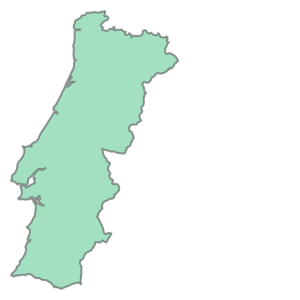

In [134]:
shape = countries.to_crs(excluder.crs).loc[["PT"]].geometry
shape.iloc[0]

We can then call the `shape_availability` function, passing the Portugal geometry and the excluder object.

In [135]:
band, transform = shape_availability(shape, excluder)

This function returns a 2-D `numpy.ndarray` and a transformation, similar to the previous `rasterio` data examples.

Eligible raster cells have a `True` and excluded cells a `False` value.

In [136]:
band

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(5662, 3404))

In [137]:
band.any()

np.True_

In [138]:
transform

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

We can use the `rasterio.plot.show()` function for plotting:

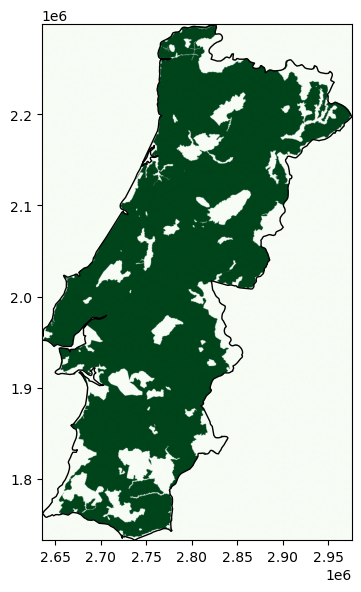

In [139]:
fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax);

How to calculate what share of the land is eligible?
1. count number of eligible raster cells
2. determine area per raster cell
3. multiply cell area with number of cells
4. divide eligible area by total land area

In [140]:
eligible_cells = float(band.sum())
cell_area = float(excluder.res**2)
eligible_area = cell_area * eligible_cells
country_area = shape.geometry.area.iloc[0]
eligible_area / country_area * 100

np.float64(79.65002907506346)

In this example, approximately 20% of Portugal's land area are covered by nature reserves and **excluded** (inverse).

Typically, **more than one dataset** is needed for a proper land eligibility analysis, i.e. we need to add more datasets to our container.
So, let's start a new exclusion container with the default CRS and resolution and add the Natura2000 data again.

In [141]:
excluder = ExclusionContainer(crs=3035, res=100)

In [142]:
url = "https://tubcloud.tu-berlin.de/s/mxgaA7wH8NsmdDi/download/Natura2000_end2021-PT.gpkg"
excluder.add_geometry(url)

As a next step, we want to add a raster dataset to the `ExclusionContainer`, namely a selection of CORINE land cover classes to include and exclude.

In [143]:
url = "https://tubcloud.tu-berlin.de/s/Mw5dwbwdsDY8zfH/download/U2018_CLC2018_V2020_20u1-PT.tif"

The raster data has categorical or continuous values. These **codes** (integers) can be referenced when adding the raster to the excluder.

First, let's add a list of **codes to exclude**. 

In [144]:
codes_to_exclude = [1, 2, 3, 4, 5, 6]

In addition to excluding those specific land use classes, we also want to exclude a **buffer** of 800 meters around those classes.


In [145]:
excluder.add_raster(url, codes=codes_to_exclude, crs=3035, buffer=800, nodata=48)

Note how we also specify what `crs` the raster is in (here: 3035) and what value represents `nodata` (here: 48).

Second, let's add a list of **codes to include**. This is done by setting the `invert` parameter to `True`, i.e. the listed codes are the only ones to be included while all others are excluded.

In [146]:
codes_to_include = [12, 13, 18, 19, 20, 21]
excluder.add_raster(url, codes=codes_to_include, crs=3035, invert=True, nodata=48)

Then, we can simply repeat the `shape_availability()` calculation and visualise the remaining available cells:

/home/fneum/miniconda3/envs/esm-ws-25-26/lib/python3.12/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


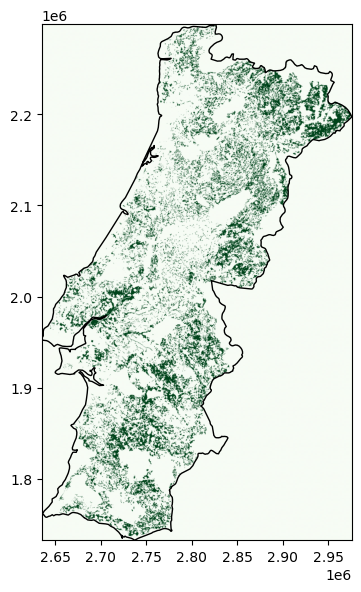

In [147]:
band, transform = shape_availability(shape, excluder)

fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax);

## Spatial and Temporal Availability

Besides calculating spatial potential for renewables development, [`atlite`](https://atlite.readthedocs.io) can also handle weather data time series and convert them to energy systems time series (i.e. production time series for wind and solar).

One famous such dataset is the [ERA5 reanalysis data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) which has historical weather data for the whole world from 1940 to 2025 at hourly resolution and on a 0.25 x 0.25 degree grid (roughly 25-30 km depending on where you are).

Accessing this functionality requires you to import the full `atlite` package:

In [148]:
import atlite

In `atlite`, the `cutout` is the basis for any of your work and calculations and contains all the weather data for a specific region and time period.

Here, we load an existing dataset which was retrieved from `ERA5` for January 2013 in Portugal:

In [149]:
cutout = atlite.Cutout("PORTUGAL-2013-01-era5.nc")
cutout

<Cutout "PORTUGAL-2013-01-era5">
 x = -9.90 ⟷ -6.00, dx = 0.30
 y = 36.00 ⟷ 42.90, dy = 0.30
 time = 2013-01-01 ⟷ 2013-02-01, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In the backend, `atlite` uses the [`xarray`](http://xarray.pydata.org/en/stable/) package. This is a multi-dimensional version of `pandas` DataFrames, which is especially useful for working with large time series of gridded data.

:::{note}
We won't cover `xarray` in detail in this course, but just think of it as a multi-dimensional version of `pandas`.
:::

In [150]:
cutout.data

<xarray.Dataset> Size: 17MB
Dimensions:           (y: 24, x: 14, time: 768)
Coordinates:
  * x                 (x) float64 112B -9.9 -9.6 -9.3 -9.0 ... -6.6 -6.3 -6.0
  * y                 (y) float64 192B 36.0 36.3 36.6 36.9 ... 42.3 42.6 42.9
  * time              (time) datetime64[ns] 6kB 2013-01-01 ... 2013-02-01T23:...
    lon               (x) float64 112B dask.array<chunksize=(14,), meta=np.ndarray>
    lat               (y) float64 192B dask.array<chunksize=(24,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 1kB dask.array<chunksize=(24, 14), meta=np.ndarray>
    wnd100m           (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    roughness         (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_toa        (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_direct     (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    temperature       (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    soil temperature  (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    runoff            (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'runoff', 'temperature', 'wind', 'influx']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2022-03-04 14:08:37 GMT by grib_to_netcdf-2.24.2: /op...

Let's quickly plot the spatial resolution and scope of this dataset:

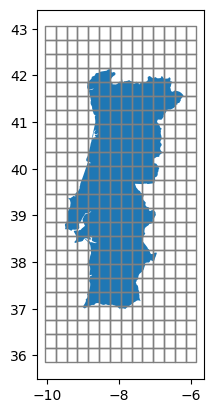

In [151]:
ax = shape.to_crs(4326).plot()
cutout.grid.plot(ax=ax, edgecolor="grey", color="None");

We can directly access, aggregate, and plot individual meteorological parameters:

In [152]:
wnd100m = cutout.data.wnd100m.mean(dim="time")
wnd100m

<xarray.DataArray 'wnd100m' (y: 24, x: 14)> Size: 1kB
dask.array<mean_agg-aggregate, shape=(24, 14), dtype=float32, chunksize=(24, 14), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 112B -9.9 -9.6 -9.3 -9.0 -8.7 ... -6.9 -6.6 -6.3 -6.0
  * y        (y) float64 192B 36.0 36.3 36.6 36.9 37.2 ... 42.0 42.3 42.6 42.9
    lon      (x) float64 112B dask.array<chunksize=(14,), meta=np.ndarray>
    lat      (y) float64 192B dask.array<chunksize=(24,), meta=np.ndarray>

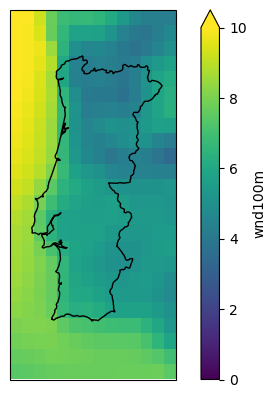

In [153]:
ax = plt.axes(projection=ccrs.PlateCarree())

wnd100m.plot(ax=ax, vmin=0, vmax=10)

shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none");

This cutout happens to also have data on the surface roughness. We can use this to scale the 100 meter wind speeds down to 10 meters using the **log law**:

$$\frac{U(z)}{U(z_r)} = \frac{\ln\left(\frac{z}{z_0}\right)}{\ln\left(\frac{z_r}{z_0}\right)}$$

In [154]:
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m

In [155]:
wnd10m = wnd100m * np.log(10 / z_r) / np.log(100 / z_r)

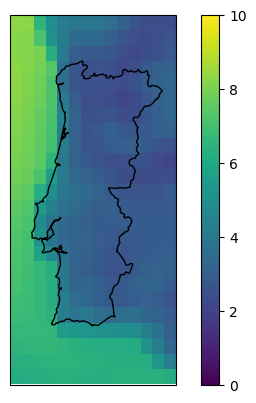

In [156]:
ax = plt.axes(projection=ccrs.PlateCarree())

wnd10m.mean(dim="time").plot(ax=ax, vmin=0, vmax=10)

shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none");

We can also build means in the spatial dimensions and investigate the behaviour of meteorological variables over time. Here, we do this for the direct solar irradiation.

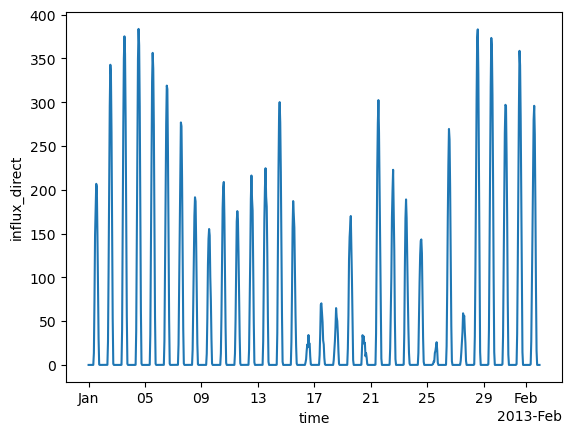

In [157]:
cutout.data.mean(dim=["x", "y"]).influx_direct.plot();

We also already saw that the weather cells are much larger than the raster cells we previously used for the land eligibility analysis. `atlite` automates this conversion for averaging fine-grained to coarse-grained rasters for all geometries in shapes when calling the `cutout.availabilitymatrix()` function, using the same arguments as the previous `shape_availability()` function. 

In [158]:
A = cutout.availabilitymatrix(shape, excluder)
A.coords

Coordinates:
  * name     (name) object 8B 'PT'
  * y        (y) float64 192B 36.0 36.3 36.6 36.9 37.2 ... 42.0 42.3 42.6 42.9
  * x        (x) float64 112B -9.9 -9.6 -9.3 -9.0 -8.7 ... -6.9 -6.6 -6.3 -6.0

`A` is an array with 3 dimensions (`name`, `x`, `y`) and very sparse data. It indicates the relative overlap of weather cell (`x`, `y`) with the geometry shape while excluding the areas excluded by the `ExclusionContainer`.

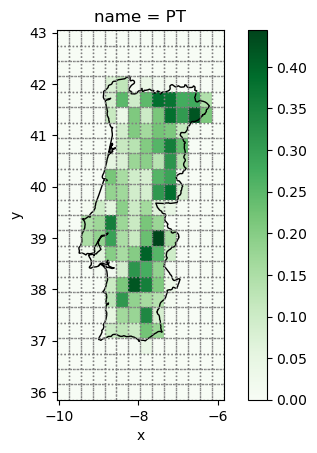

In [159]:
fig, ax = plt.subplots()
A.sel(name="PT").plot(cmap="Greens")
shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
cutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");

The **availability matrix** `A` can now be used as a layout matrix in the conversion functions of `atlite` from wind speeds to capacity factors and electricity production potential. The general approach would be to weigh the availabilities with the area per grid cell and the allowed deployment density (capacity per area). These two factors can give you an estimate of the electricity production potential for the corresponding geometry shapes.

In [160]:
import xarray as xr

cap_per_sqkm = 2  # 2 MW/km^2
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6  # in km^2
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A.stack(spatial=["y", "x"]) * area * cap_per_sqkm

This code calculates the potential installed capacity in each grid cell based on its available area. It first computes the area of each cell in square kilometers, then aligns this area information with the availability matrix `A`, whose values between 0 and 1 indicate the eligible share of each cell. After reshaping both datasets so that their cells correspond directly, the eligible area in each cell is multiplied by a capacity density (`cap_per_sqkm`), yielding the potential capacity per grid cell in megawatts.

Using the resulting `capacity_matrix` which contains for each grid cell the maximum deployable capacity, we can now calculate the capacity factor time series for Portugal.

In [161]:
wind = cutout.wind(matrix=capacity_matrix, turbine="Vestas_V90_3MW", index=shape.index)

/home/fneum/miniconda3/envs/esm-ws-25-26/lib/python3.12/site-packages/atlite/resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


Let’s see how the total wind power potential looks like:

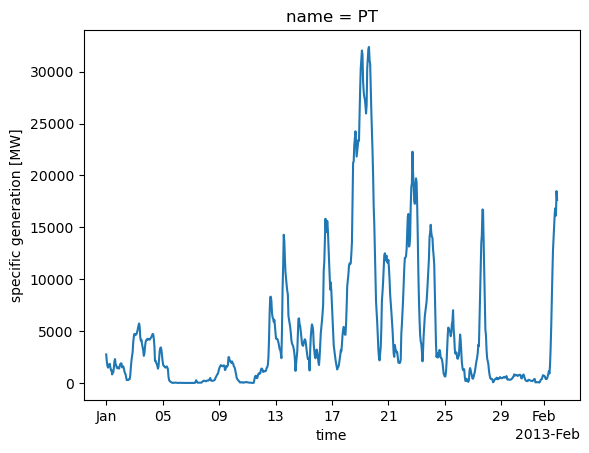

In [162]:
wind.plot();

Analogously, we can also determine the potential power generation time series of solar photovoltaics parks:

:::{note}
For simplicity, we assume the same deployment density and land eligibility criteria as for wind. Note that in reality, different eligibility criteria apply for solar and wind developments.
:::

For that, we have to specify the [type of panel](https://en.wikipedia.org/wiki/Solar_panel#Technology) (CSi refers to a crystalline silicon panel), the orientation (azimuth of 180° means southward orientation, slope refers to inclination angle from the ground).

In [163]:
pv = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    matrix=capacity_matrix,
    index=shape.index,
)

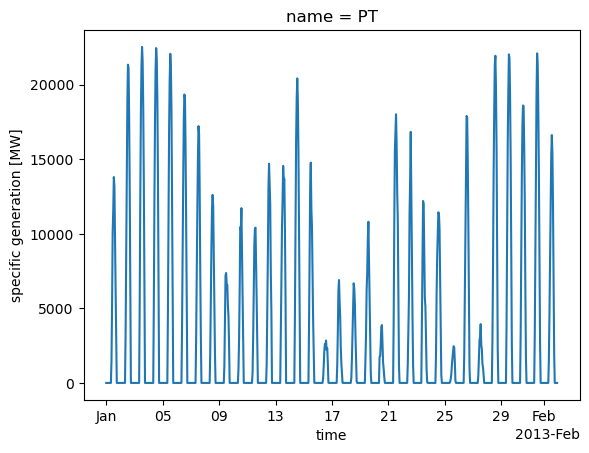

In [164]:
pv.plot();

## Exercises

### Exercise 1: Land Exclusion Sensitivities

Tweak some parameters of the land exclusion calculation for wind deployment and observe the changes in available area and resulting wind power potential. For instance:

1. Vary the [CORINE land classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html),
2. Vary the buffer distance, for instance, to 0m or 2000m,
3. Add the [GEBCO topography data](https://www.gebco.net/) loaded at the beginning of the tutorial to the exclusion calculator and exclude areas above 1000m elevation.


### Exercise 2: Solar PV Orientation Sensitivities

The orientation of solar panels plays a decisive role in determining their potential power generation time series. Explore this aspect by performing the following sensitivity analysis on the solar PV setup for Portugal in January:

**Task 1:** Plot the total energy yield in January as a function of the slope of the panels oriented towards the South (0° means horizontal orientation, 90° means vertical orientation) in steps of 10°. What is the optimal tilt angle? Why might the value be higher than typically recommended for PV panels?

**Task 2:** Plot the power production profile for January 1 for the azimuth angles 0°, 90°, 180°, 270° of panels tilted at a 30° angle (i.e. varying north, east, south west orientations). What orientation does each angle represent? Describe the differences you observe.

**Task 3:** The `cutout.pv()` function can also consider multiple options for tracking features of solar panels as listed below. Tracking in solar panel systems refers to the mechanism that allows panels to move and orient themselves towards the sun, maximizing their exposure to sunlight and thereby increasing their electricity output. The default settings in `atlite` assume no tracking. Explore and describe the power output profile for different tracking options for January 31. How much more expensive in percent can the equipment for tracking be to achieve the same cost per unit of electricity produced as a fixed panel (if it only operated in January)?

Available tracking options in `atlite` are:

- `tracking='horizontal'` for 1-axis horizontal tracking: This setting positions solar panels to rotate around a horizontal axis, allowing them to follow the sun's path from east to west.
- `tracking='vertical'` for 1-axis vertical tracking: In this mode, the solar panels rotate around a vertical axis, which can be advantageous in high latitudes for better sun capture throughout the day.
- `tracking='dual'` for 2-axis tracking: This advanced system allows panels to track the sun both horizontally and vertically, maximizing solar exposure and energy capture throughout the day and year.

For all calculations, disregard land eligibility criteria and assume a uniform distribution of solar panels across Portugal.